In [45]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기

In [46]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 데이터 전처리

In [47]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
2
train.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [48]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [49]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [50]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


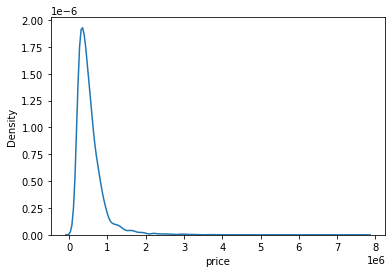

In [51]:
sns.kdeplot(y)
plt.show()

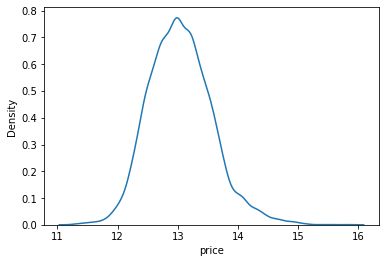

In [52]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 모델 튜닝

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [55]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [56]:
random_state=777

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [57]:
#각 모델의 RMSE 확인
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 175490.8133022761,
 'XGBRegressor': 165217.7764400154,
 'LGBMRegressor': 166655.54385463873,
 'RandomForestRegressor': 171987.01600275023}

In [58]:
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [1000,1500,2000],
    'max_depth': [8,16,32,64],
}

model = LGBMRegressor(random_state=random_state)

# 랜덤서치

0) 정의 

-> GridSearch와 동일한 방식으로 사용하지만, 모든 조합을 다 시도하지 않고 각 반복마다 임의의 값을 대입해 지정한 횟수만큼만 평가

 

1) 함수 

sklearn.model_selection.RandomizedSearchCV

 

· estimator: 모델객체 지정 

· param_distributions: 하이퍼파라미터 목록을 dictionary로 전달 ('파라미터명': [파라미터 값 list] 형식)

· n_iter: 파라미터 검색 횟수

· scoring: 평가 지표
· refit: best parameter를 정할 때 사용하는 평가지표로, scoring에 여러 평가지표를 설정한 경우 설정한다.

· cv: 교차검증 시 fold 개수 

· n_jobs: 사용할 CPU 코어 개수 (None: 1 (기본값), -1: 모든 코어 다 사용) 

In [59]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = RandomizedSearchCV(model, param_grid, n_iter = 25,scoring='neg_mean_squared_error', \
                              cv=3, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [60]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [1000,1500,2000],
    'max_depth': [8,16,32,64],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


,n_estimators,max_depth,learning_rate,score,RMSLE
20,2000,64,0.01,-0.026287,0.162132
0,2000,16,0.01,-0.026290,0.162141
21,1000,64,0.05,-0.026436,0.162591
13,1000,32,0.05,-0.026436,0.162591
24,1500,32,0.01,-0.026486,0.162746
8,1500,16,0.01,-0.026510,0.162818
10,1000,16,0.05,-0.026527,0.162871
5,1500,8,0.01,-0.026618,0.163150
1,1500,64,0.05,-0.026620,0.163155
23,1500,32,0.05,-0.026620,0.163155


# 파라미터 튜닝

In [65]:
model = LGBMRegressor(n_estimators=2000,max_depth=64,learning_rate=0.1)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.14137291, 13.11229961, 14.01503243, ..., 13.05611005,
       12.677721  , 13.01602428])

In [66]:
prediction = np.expm1(prediction)
prediction

array([ 509594.68044254,  494992.35073371, 1220817.90658216, ...,
        467945.87420772,  320525.74437256,  449558.85515152])

# 모델 저장

In [67]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [68]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0162')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0162.csv saved!
[CV] END learning_rate=0.01, max_depth=16, n_estimators=2000; total time=  10.1s
[CV] END .learning_rate=0.05, max_depth=8, n_estimators=1500; total time=  12.7s
[CV] END .learning_rate=0.1, max_depth=64, n_estimators=1000; total time=   7.1s
[CV] END learning_rate=0.05, max_depth=16, n_estimators=2000; total time=  14.6s
[CV] END .learning_rate=0.1, max_depth=64, n_estimators=2000; total time=  11.6s
[CV] END .learning_rate=0.01, max_depth=8, n_estimators=1000; total time=   8.9s
[CV] END learning_rate=0.05, max_depth=32, n_estimators=1000; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=64, n_estimators=1000; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=1000; total time=   7.9s
[CV] END learning_rate=0.05, max_depth=64, n_estimators=2000; total time=  10.3s
[CV] END .learning_rate=0.1, max_depth=32, n_estimators=1000; total time=   5.5s
[CV] END learning_rate=0.01, 

# 회고

이번 프로젝트는 노드부터 이해가 안갔다,,,

아직은 내게 캐글은 너무 어렵달까ㅜㅜ

이해가 안가서 뭐를 제대로 건드리지도 못하고 끝낼 뻔 했다.

11만점에 만족하고 포기할까 싶었을 때 그냥 마지막으로 GridSearchCV가 뭔지 검색을 해봤다.

설명해주는 이미지들 중에 

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbbiSBu%2FbtqF3T0FGSi%2FvnJ5vH9oANNJL2SFdZTrA0%2Fimg.png)
이 사진을 보게 됐다. 

혼공 시간에 병률님께서 열심히 설명해주셨던 사진이었는데,

잠깐 기억하기론 그리드서치보다 랜덤서치가 높은 성공률을 보이는 아이가 나올 확률이 높다

이유는 그리드서치는 평균적으로 찾기 때문에 갑자기 움푹 파인 곳은 찾기가 힘들고

랜덤서치는 운좋게 찾을 수 있기 때문에 랜덤서치가 더 좋은 아이를 찾을 확률이 조오오오금 더 높다는 거였다.

물론 결론은 둘 다 돌려보고 더 좋은 모델을 쓰는게 낫다는 것이었지만 나는 그리드서치로 열심히 해보았기 때문에

랜덤서치를 사용해보기로 했다.

랜덤서치로 파라미터를 여러번 수정해보다가 운좋게 10만점 짜리 아이를 찾게 되었다. ㅎㅎㅎ(병률님 감사합니다 ㅎㅅㅎ)

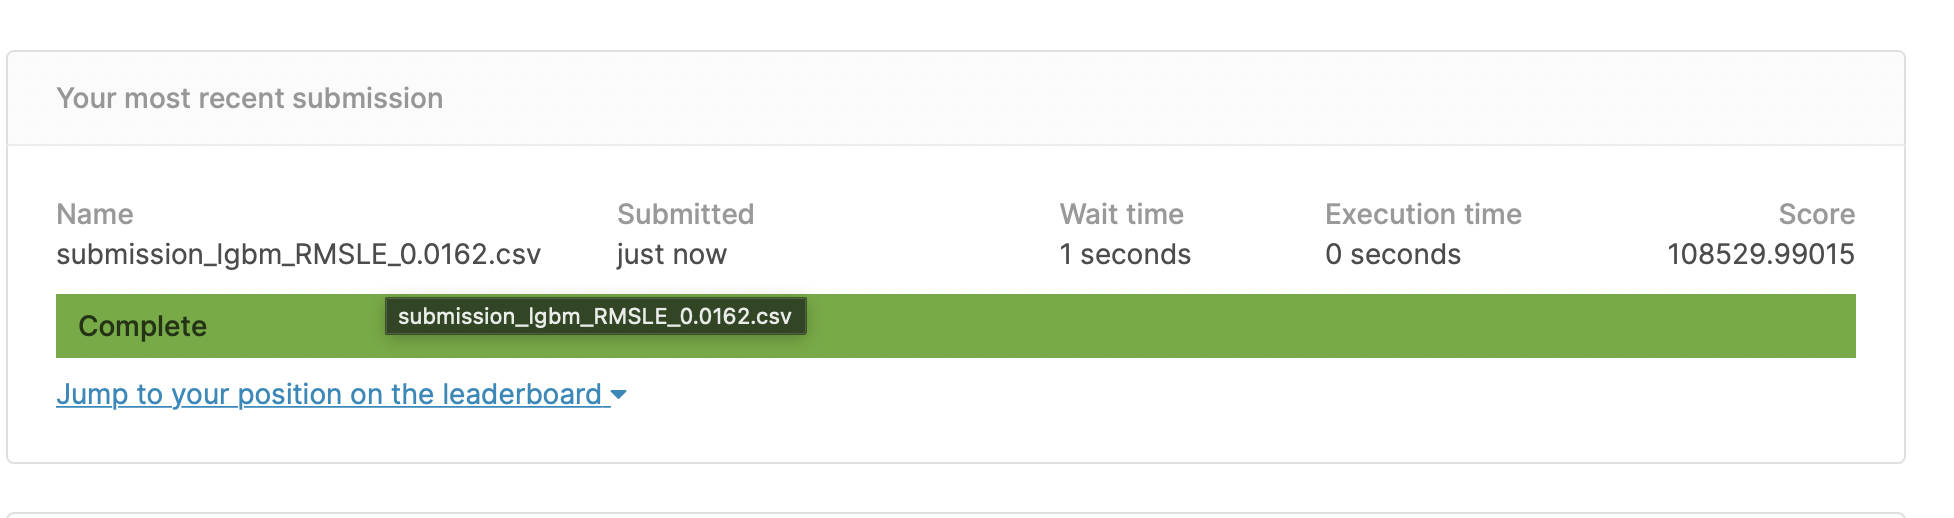

많이 어려웠지만 혼공 때 배운 내용을 한번 더 복습&실습 할 수 있는 기회였다.

캐글이 어렵긴하지만 결국 내가 도전할 대회들이기 때문에 노드를 더 공부해서 여러 대회에 도전해보고 싶다.